In [1]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras import regularizers
from tensorflow.keras.losses import categorical_crossentropy

import matplotlib.pyplot as plt
from datetime import datetime

2023-12-14 18:51:19.241662: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
  # Invalid device or cannot modify virtual devices once initialized.
  print('nop')

nop


2023-12-14 18:51:20.571273: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-12-14 18:51:20.572095: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-12-14 18:51:21.850965: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2023-12-14 18:51:21.850999: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: debajyoti-G7-7790
2023-12-14 18:51:21.851011: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: debajyoti-G7-7790
2023-12-14 18:51:21.851127: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 525.147.5
2023-12-14 18:51:21.851158: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 525.147.5
2023-12-14 18:51:21.851168: I tensorflow/stream_executor/cuda/cu

In [3]:
# Define parameters
input_shape = (50, 50, 3)  # Adjust based on your dataset
batch_size = 256
num_classes = 50
epoch = 200

# train_data_dir = './Dataset/BanglaLekha-Isolated/BanglaLekha-Isolated/Images/'
train_data_dir = './Dataset/b/Train/'
# test_data_dir = './dataset/RESIZED_TESTING_DATA'

# Create data generators with validation split
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    validation_split=0.2  # 20% of the data will be used for validationfrom datetime import datetime
)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=input_shape[:2],
    # color_mode='grayscale',
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'  # Set this to 'validation' for the validation set
)

validation_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=input_shape[:2],
    # color_mode='grayscale',
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'  # Set this to 'training' for the training set
)

# Define a function to create a model with a specific base model
def create_transfer_model(base_model):
    base_model.trainable = False  # Freeze pre-trained layers
    
    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x) #layers.Dense(512, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    predictions = layers.Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=predictions)
    
    return model

# List of base models to try
base_model = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
    


Found 9600 images belonging to 50 classes.
Found 2400 images belonging to 50 classes.


2023-12-14 18:51:22.656184: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-14 18:51:22.656627: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set


In [4]:
model = create_transfer_model(base_model)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50, 50, 3)]  0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 25, 25, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 25, 25, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 25, 25, 32)   0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

In [5]:
initial_strength = 0.01
final_strength = 0.0001
decay_epochs = 10


class DynamicRegularizationCallback(tf.keras.callbacks.Callback):
    def __init__(self, initial_strength, final_strength, decay_epochs):
        super(DynamicRegularizationCallback, self).__init__()
        self.initial_strength = initial_strength
        self.final_strength = final_strength
        self.decay_epochs = decay_epochs

    def on_epoch_end(self, epoch, logs=None):
        dynamic_strength = self.initial_strength - (epoch / self.decay_epochs) * (self.initial_strength - self.final_strength)
        tf.keras.backend.set_value(self.model.dynamic_strength, dynamic_strength)

# Create an instance of the callback
dynamic_regularization_callback = DynamicRegularizationCallback(initial_strength, final_strength, decay_epochs)

# Adjust the custom loss function to take epoch as an argument
def custom_loss_with_dynamic_regularization(epoch):
    def loss_function(y_true, y_pred):
        cross_entropy = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
        l2_regularization = tf.keras.backend.get_value(model.dynamic_strength) * tf.reduce_sum([tf.reduce_sum(tf.square(w)) for w in model.trainable_weights])
        total_loss = cross_entropy + l2_regularization
        return total_loss

    return loss_function

# Create a placeholder for dynamic_strength in the model
model.dynamic_strength = tf.Variable(0.0, trainable=False)


2023-12-14 18:51:23.799525: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2023-12-14 18:51:23.799545: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2023-12-14 18:51:23.800866: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2023-12-14 18:51:24.026544: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-12-14 18:51:24.026854: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2599990000 Hz


Epoch 1/200
 1/37 [..............................] - ETA: 1:14 - loss: 12.7800 - accuracy: 0.0234

2023-12-14 18:51:26.176969: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2023-12-14 18:51:26.176991: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.


 2/37 [>.............................] - ETA: 10s - loss: 24.3398 - accuracy: 0.0410 

2023-12-14 18:51:26.402423: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2023-12-14 18:51:26.407861: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2023-12-14 18:51:26.413225: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/20231214-185123_mobilenetv2_1.00_224/train/plugins/profile/2023_12_14_18_51_26
2023-12-14 18:51:26.416017: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to logs/20231214-185123_mobilenetv2_1.00_224/train/plugins/profile/2023_12_14_18_51_26/debajyoti-G7-7790.trace.json.gz
2023-12-14 18:51:26.420428: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/20231214-185123_mobilenetv2_1.00_224/train/plugins/profile/2023_12_14_18_51_26
2023-12-14 18:51:26.420513: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for memory_profile.json.gz t

37/37 [==============================] - 14s 345ms/step - loss: 40.0864 - accuracy: 0.1243 - val_loss: 17.6752 - val_accuracy: 0.1033
Epoch 2/200
37/37 [==============================] - 12s 324ms/step - loss: 12.5942 - accuracy: 0.2435 - val_loss: 10.1567 - val_accuracy: 0.1237
Epoch 3/200
37/37 [==============================] - 12s 319ms/step - loss: 7.8355 - accuracy: 0.2994 - val_loss: 6.5971 - val_accuracy: 0.2448
Epoch 4/200
37/37 [==============================] - 12s 330ms/step - loss: 5.8084 - accuracy: 0.3460 - val_loss: 5.6471 - val_accuracy: 0.1645
Epoch 5/200
37/37 [==============================] - 12s 323ms/step - loss: 4.5485 - accuracy: 0.3811 - val_loss: 4.6748 - val_accuracy: 0.2287
Epoch 6/200
37/37 [==============================] - 12s 321ms/step - loss: 3.6746 - accuracy: 0.4248 - val_loss: 3.6991 - val_accuracy: 0.3264
Epoch 7/200
37/37 [==============================] - 12s 322ms/step - loss: 3.1185 - accuracy: 0.4462 - val_loss: 3.2338 - val_accuracy: 0.3724


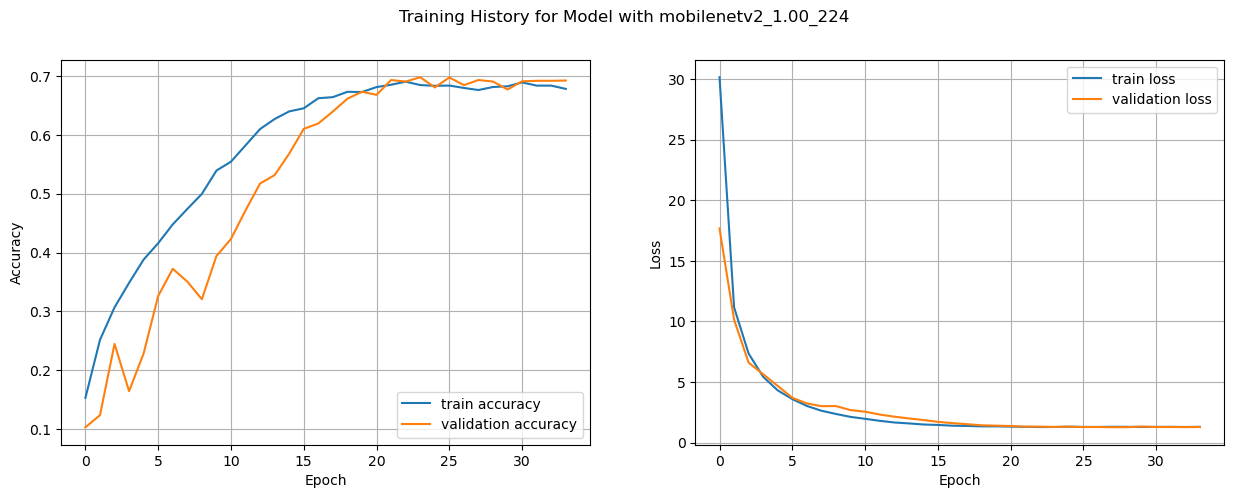

In [6]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.1,
    decay_steps=10,
    decay_rate=0.9)
    # staircase=True)

custom_optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
# model.compile(optimizer=custom_optimizer, loss=custom_loss_with_dynamic_regularization(epoch=0), metrics=['accuracy'])
    
model.compile(optimizer=custom_optimizer, loss=custom_loss_with_dynamic_regularization(epoch=0), metrics=['accuracy'])
# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.02, patience=5, restore_best_weights=True)
# Define TensorBoard callback
log_dir = "logs/" + datetime.now().strftime("%Y%m%d-%H%M%S") + "_" + base_model.name
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Train the model with validation data and early stopping
h = model.fit(
    train_generator,
    epochs=epoch,  # Adjust as needed
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    callbacks=[early_stopping, tensorboard_callback, dynamic_regularization_callback]
)

# Save the model or store the results for later comparison
model.save('./models/full_custom_loss_model_with_' + base_model.name + '_with_validation_early_stopping.h5')

# Plot and save the training history as a PDF
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(h.history['accuracy'], label='train accuracy')
plt.plot(h.history['val_accuracy'], label='validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(h.history['loss'], label='train loss')
plt.plot(h.history['val_loss'], label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
# plt.ylim([0, 1])
plt.legend(loc='upper right')

plt.suptitle('Training History for Model with ' + base_model.name)
plt.savefig('./results/full_cutom_loss_training_history_' + base_model.name + '.pdf')
plt.show()

In [7]:
tf.__version__

'2.4.1'